# Assignment 1 - Image Classification

This notebook contains the required task for the first assignment of the Deep Network Development course. Read the task description and fill in the empty code cells. Each section represents an implementation stage of an image classifier, from loading and inspecting the dataset to implementing and training a Convolutional Neural Network architecture. The sections guide you but you do not have to follow that specific order.

Copy this notebook to your drive (File -> Save a copy in Drive), edit it, and upload the final .ipynb file to [Canvas](https://canvas.elte.hu). If you using Colab notebook, save it as .ipynb and upload it. If you have your own machine with Jupyter installed, you can work there as well. Upload only the .ipynb file.


## Rules and Comments
- From the list of datasets and architectures listed in Canvas, each student was assigned **1 architecture** to use within this assignment. Please confirm yours in the Canvas assignment's description.
- This is a DL class so to pass the homework you do have to implement a working classifier, just loading the data or having a "random-guess" performance is not enough.
- As always, copying others' code will make you fail the homework automatically (and thus the course).
- **Deadline is October 17th 11:59 PM** (For late submission it is October 23rd 11:59PM)
- Make sure your code can be run from an empty state (use Runtime -> Run all in the menu after restarting the notebook)
- Feel free to add more code cells as needed. But don't put code into external Python files.
- Please add your name, Neptun ID, and task details below.

**Name: Roland Szögi**  
**Neptun ID: XNLZX4**
**Network: AlexNet**
**Objects: Fruits 360**

## Task description

Your task is to compare the performance of a given pre-trained model and a modified version of it, using a given dataset. The datasets contain images as input and class labels as target, thus you have to solve a Supervised Machine Learning Classification problem.

Steps
1. If your dataset has more than 5 classes, then select 5 classes of your choice (explain why). If your dataset has 5 or less classes, ignore this step.
2. The dataset should be split into train, validation and test sets. Some datasets already have these splits, otherwise, you can split the training set into validation and test sets.
3. Use the test set to do inference with the pre-trained model. Calculate the accuracy of the pre-trained model.
4. Modify the pre-trained model and train it with the train/validation sets. Modifying means removing/replacing/adding layers. We recommend changing the: head (you need to do this because the pre-trained models were created to predict 1000 classes from Imagenet, however, in your case, the number of classes is different, so you must change the head); backbone (remove/replace layers in the backbone. Be aware that once you do that, you need to be able to adjust the networks output dimensions by changing the properties like filter size, padding, etc)
5. Use the test set to do inference with the newly modified/trained model. Calculate the accuracy.
6. Compare the results from the pre-trained model and the modified version.
7. Explain the differences.
Please submit only the notebook to Canvas. (Do not upload the dataset nor the models)

There is no expected percentage of accuracy, but **your accuracy should be better than random guessing and your loss has to decrease throughout the epochs**. We expect you to show visualizations (matplotlib, seaborn, ...) of the accuracy, loss, and confusion matrix. Use Early stopping and save the best model while training your network.


# In order to get your grade for the assignment, you must defend it by answering questions during the designated practice time.


There are some example questions at the end of the notebook.

## 0. Import libraries
Import all libraries/packages that you believe will help you fulfil the task, but **for the network only PyTorch can be used.**

In [1]:
import copy
import time

import torch
import torchvision #has various utils functions, including loading datasets
import torchvision.transforms as transforms #common image transformations

import torch.nn as nn #creating neural network https://pytorch.org/docs/stable/nn.html
import torch.nn.functional as F #functional api for layers,...
import torch.optim as optim #for optimization algorithm
import matplotlib.pyplot as plt #for visualization
import numpy as np #for basic array operations

from torchvision.datasets import ImageFolder
from torch.utils.data import Subset
from torch.optim import lr_scheduler
#Set up GPU or CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


## 1. Dataset
Load the dataset you were given. Images should be stored in an X variable and your labels in a Y variable. Split your dataset into train, validation and test set and pre-process your data for training.

In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od
import pandas

od.download("https://www.kaggle.com/moltean/fruits")

Skipping, found downloaded files in "./fruits" (use force=True to force download)


In [ ]:
path = "/content/fruits/fruits-360_dataset/fruits-360/"
train_root = path + "Training"
test_root = path + "Test"

In [ ]:

#transform data to tensor and normalize with mean=0.5 and standard deviation=0.5 for each channel
transform = transforms.Compose(
    [transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
#     transforms.RandomAffine(degrees=(5, 50), translate=(0.1, 0.3), scale=(0.9, 1.1)),
#     transforms.RandomPerspective(distortion_scale=0.2),
#     transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# load training set and apply transform
trainset = torchvision.datasets.ImageFolder(root=train_root, transform=transform)
testset = torchvision.datasets.ImageFolder(root=test_root, transform=transform)

# the original classes and labels:
#class_dict = {v: k for k, v in trainset.class_to_idx.items()}
#class_dict

# I will use the following classes: "banana", "cauliflower", "corn", "fig", "orange".
# I choose these classes because these are present in both the Imagenet dataset and the Fruits 360 dataset, this way AlexNet has a chance to predict the correct labels.

# relabeling the images
target_dict = {16: 0, 25: 1, 35: 2, 41: 3, 77:4}

for i in range(len(trainset)):
  if trainset.imgs[i][1] in target_dict:
    trainset.imgs[i] = (trainset.imgs[i][0], target_dict[trainset.imgs[i][1]])
  else:
    trainset.imgs[i] = (trainset.imgs[i][0], -1)

for i in range(len(testset)):
  if testset.imgs[i][1] in target_dict:
    testset.imgs[i] = (testset.imgs[i][0], target_dict[testset.imgs[i][1]])
  else:
    testset.imgs[i] = (testset.imgs[i][0], -1)


# keeping only the images in the 5 classes

idx = [i for i in range(len(trainset)) if trainset.imgs[i][1] in range(5)]
trainset = Subset(trainset, idx)

idx = [i for i in range(len(testset)) if testset.imgs[i][1] in range(5)]
testset = Subset(testset, idx)


#### Splitting the dataset

In [ ]:
# there is no validation set so I will use half of the test set for validation

num_validation = int(0.5 * len(testset))
num_test = len(testset) - num_validation

validationset, testset = torch.utils.data.random_split(testset, [num_validation, num_test])


#### Pre-processing the dataset (data loader with transformations)

In [ ]:
batch_size = 16

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
validationloader = torch.utils.data.DataLoader(validationset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)


#### Check the number of images and class balances in the  train, validation and test set

In [ ]:
print(f"Number of images in the training set: {len(trainset)}")
print(f"Number of images in the training set: {len(validationset)}")
print(f"Number of images in the test set: {len(testset)}")

Number of images in the training set: 2823
Number of images in the training set: 472
Number of images in the test set: 472


#### Loading one example for each object type from the dataset
Show some images and labels of your dataset

fig,banana,fig,corn,fig,cauliflower,fig,fig,corn,orange,cauliflower,orange,fig,banana,orange,fig


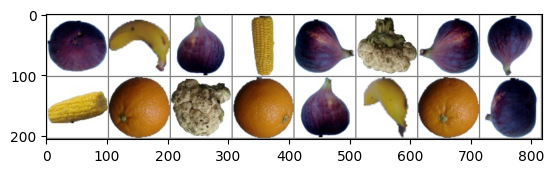

In [ ]:
# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     #because images were normalized when loaded, for visualization purposes we denormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) #reorder the channels
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels =next(dataiter)    # or in previous version: dataiter.next()

dict2 = {0: "banana", 1: "cauliflower", 2: "corn", 3: "fig", 4:"orange"}
# print labels
print(','.join(dict2[int(labels[j])] for j in range(batch_size)))
# show images
imshow(torchvision.utils.make_grid(images))

## 2. Convolutional Neural Network Architecture
Implement the original CNN architecture you were given. Reduce the size of the given model by removing some layers and parameters with less influence. Define the optimizer and loss function. Train your network and save it. Remember to use Early stopping and show results.

#### Implement the original architecture

In [ ]:
map_dict = {0: 954, 1:938, 2:987, 3:952, 4:950} # to map the 0-4 labels to the Imagenet labels

def labels_to_imagenet(l):
  return [map_dict[x] if (x in map_dict) else 0 for x in l]

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True).to(device)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model.eval()
correct = 0
total = 0
labels_total=[]
prediction_total=[]
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images.to(device))
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        predicted=predicted.cpu()
        labels_total=np.append(labels_total,labels.numpy(), axis=0)
        prediction_total=np.append(prediction_total,predicted.numpy(), axis=0)
        total += labels.size(0)
        imagenet_labels = torch.tensor(labels_to_imagenet([int(x) for x in labels]))
        correct += (predicted == imagenet_labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 31 %


#### Summary of the original architecture

In [ ]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
# check the size of the images
trainset[0][0].size()

torch.Size([3, 100, 100])

In [ ]:
from torchsummary import summary

summary(model, (3, 100, 100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 24, 24]          23,296
              ReLU-2           [-1, 64, 24, 24]               0
         MaxPool2d-3           [-1, 64, 11, 11]               0
            Conv2d-4          [-1, 192, 11, 11]         307,392
              ReLU-5          [-1, 192, 11, 11]               0
         MaxPool2d-6            [-1, 192, 5, 5]               0
            Conv2d-7            [-1, 384, 5, 5]         663,936
              ReLU-8            [-1, 384, 5, 5]               0
            Conv2d-9            [-1, 256, 5, 5]         884,992
             ReLU-10            [-1, 256, 5, 5]               0
           Conv2d-11            [-1, 256, 5, 5]         590,080
             ReLU-12            [-1, 256, 5, 5]               0
        MaxPool2d-13            [-1, 256, 2, 2]               0
AdaptiveAvgPool2d-14            [-1, 25

#### Implement the new architecture with less parameter

In [ ]:
class MyModel(nn.Module):
  def __init__(self, model, num_classes=5):
    super().__init__()
    self.backbone = model.features[:10]
    self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.classifier = nn.Sequential(nn.Linear(1024, num_classes))

  def forward(self, x):
    out = self.backbone(x)
    out = self.maxpool(out)
    out = torch.flatten(out, 1) # flatten all dimensions except batch
    out = self.classifier(out)
    return out



In [ ]:
mymodel = MyModel(model).to(device)

In [ ]:
for param in mymodel.backbone.parameters():
  param.requires_grad = False

#### Summary of the new architecture

In [ ]:
mymodel

MyModel(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
  )
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (classifier): Sequential(
    (0): Linear(in_features=1024, out_features=5, bias=True)
  )
)

In [ ]:
summary(mymodel, (3, 100, 100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 24, 24]          23,296
              ReLU-2           [-1, 64, 24, 24]               0
         MaxPool2d-3           [-1, 64, 11, 11]               0
            Conv2d-4          [-1, 192, 11, 11]         307,392
              ReLU-5          [-1, 192, 11, 11]               0
         MaxPool2d-6            [-1, 192, 5, 5]               0
            Conv2d-7            [-1, 384, 5, 5]         663,936
              ReLU-8            [-1, 384, 5, 5]               0
            Conv2d-9            [-1, 256, 5, 5]         884,992
             ReLU-10            [-1, 256, 5, 5]               0
        MaxPool2d-11            [-1, 256, 2, 2]               0
           Linear-12                    [-1, 5]           5,125
Total params: 1,884,741
Trainable params: 5,125
Non-trainable params: 1,879,616
-----------------------

## 3. Training

#### Define your loss function

In [ ]:
criterion = nn.CrossEntropyLoss()

#### Define your optimizer

In [ ]:
optimizer = optim.Adam(mymodel.parameters(), lr=0.0001)

#### Train your network

In [ ]:
NUM_EPOCHS = 50
patience = 5
counter = 0
total_loss_h=[]
total_vloss_h=[]
train_accuracy = []
validation_accuracy = []

best_acc = 0
for epoch in range(NUM_EPOCHS):  # loop over the dataset multiple times
    print(f'Epoch {epoch}:')

    running_loss = 0
    correct = 0
    n = 0


    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        #inputs, labels = data
        inputs, labels = data[0].to(device), data[1].to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = mymodel(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step() # updating the weights of the network

        # print statistics
        running_loss += loss

        _, predicted = torch.max(outputs.data, 1)
        #predicted=predicted.cpu()
        total = labels.size(0)
        correct += (predicted == labels).sum().item()
        n += labels.size(0)

    loss = running_loss.detach().item()
    acc = correct/n
    print(f"loss = {(loss):.4f}  accuracy = {(acc):.4f}")
    total_loss_h.append(loss)
    train_accuracy.append(acc)

    with torch.no_grad():
      running_loss = 0
      correct = 0
      n = 0


      for i, data in enumerate(validationloader, 0):
          # get the inputs; data is a list of [inputs, labels]
          #inputs, labels = data
          inputs, labels = data[0].to(device), data[1].to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward + backward + optimize
          outputs = mymodel(inputs)
          loss = criterion(outputs, labels)

         # print statistics
          running_loss += loss

          _, predicted = torch.max(outputs.data, 1)
          #predicted=predicted.cpu()
          total = labels.size(0)
          correct += (predicted == labels).sum().item()
          n += labels.size(0)

      loss = running_loss.detach().item()
      acc = correct/n
      print(f"vloss = {(loss):.4f}  vaccuracy = {(acc):.4f}")
      total_vloss_h.append(loss)
      validation_accuracy.append(acc)

      if acc > best_acc:
        best_acc = acc
        best_weights = copy.deepcopy(mymodel.state_dict())
        counter = 0
      else:
        counter +=1


      print(f"early stopping counter = {counter}")

      if counter == patience:
        mymodel.load_state_dict(best_weights)
        break

print('Finished Training')

Epoch 0:
loss = 89.1637  accuracy = 0.8650
vloss = 8.6565  vaccuracy = 0.9131
early stopping counter = 0
Epoch 1:
loss = 7.9491  accuracy = 0.9989
vloss = 6.0255  vaccuracy = 0.9364
early stopping counter = 0
Epoch 2:
loss = 3.4482  accuracy = 0.9993
vloss = 5.2825  vaccuracy = 0.9449
early stopping counter = 0
Epoch 3:
loss = 2.0498  accuracy = 1.0000
vloss = 4.3009  vaccuracy = 0.9576
early stopping counter = 0
Epoch 4:
loss = 1.3593  accuracy = 1.0000
vloss = 3.9168  vaccuracy = 0.9470
early stopping counter = 1
Epoch 5:
loss = 0.9655  accuracy = 1.0000
vloss = 4.0549  vaccuracy = 0.9534
early stopping counter = 2
Epoch 6:
loss = 0.7577  accuracy = 1.0000
vloss = 4.5283  vaccuracy = 0.9513
early stopping counter = 3
Epoch 7:
loss = 0.5847  accuracy = 1.0000
vloss = 4.2688  vaccuracy = 0.9492
early stopping counter = 4
Epoch 8:
loss = 0.4755  accuracy = 1.0000
vloss = 4.5634  vaccuracy = 0.9449
early stopping counter = 5
Finished Training


#### Show the loss on training and validation sets

(0.0, 10.0)

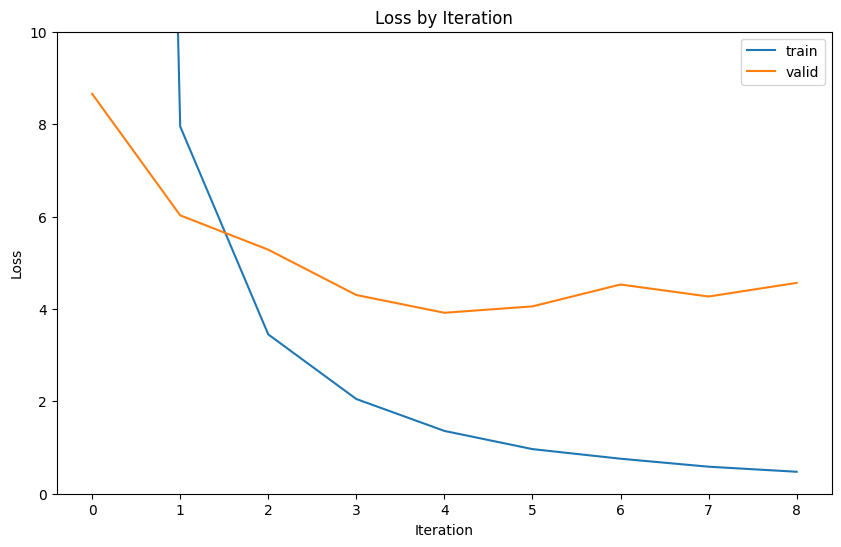

In [ ]:
plt.figure(figsize=(10,6))
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss by Iteration')

plt.plot(total_loss_h)
plt.plot(total_vloss_h)
plt.legend(['train', 'valid'])
plt.ylim((0,10))

#### Show the accuracy on training and validation sets

(0.0, 1.5)

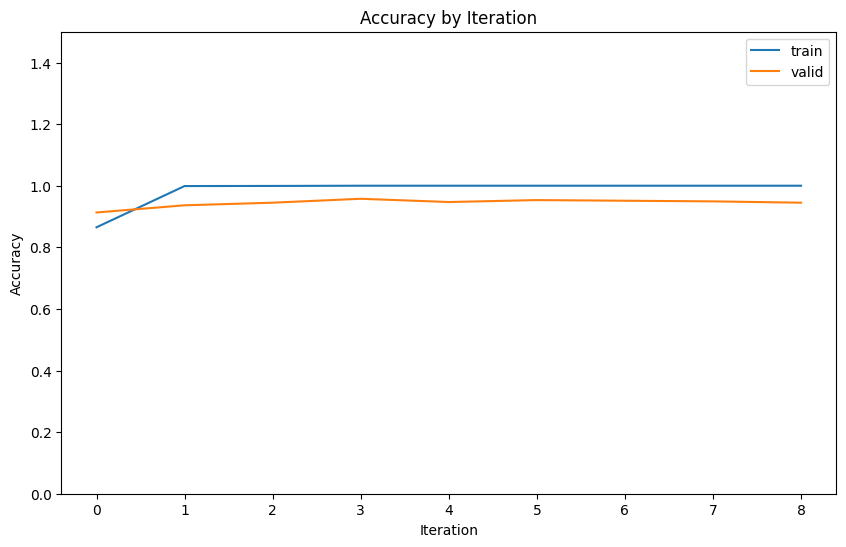

In [ ]:
plt.figure(figsize=(10,6))
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Accuracy by Iteration')

plt.plot(train_accuracy)
plt.plot(validation_accuracy)
plt.legend(['train', 'valid'])
plt.ylim((0,1.5))

#### Save your trained CNN

In [ ]:
PATH = './mymodel.pth'
torch.save(mymodel.state_dict(), PATH)

## 4. Evaluation and Testing
Load your trained CNN and evaluate it on the test set.
Show the confusion matrix on the test set.
Show some predictions on the test set (3 is enough) by plotting the image and printing the prediction and ground truth.
Show some missed predictions (3 is enough) and try to explain why it was difficult for the model to recognize these images.

#### Evaluate your model

In [ ]:
mymodel = MyModel(model).to(device)
mymodel.load_state_dict(torch.load(PATH))

<All keys matched successfully>

#### Show the test accuracy next to the training and validation

In [ ]:
correct = 0
total = 0
labels_total=[]
prediction_total=[]
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in trainloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = mymodel(images.to(device))
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        predicted=predicted.cpu()
        labels_total=np.append(labels_total,labels.numpy(), axis=0)
        prediction_total=np.append(prediction_total,predicted.numpy(), axis=0)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the train images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the train images: 100 %


In [ ]:
correct = 0
total = 0
labels_total=[]
prediction_total=[]
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in validationloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = mymodel(images.to(device))
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        predicted=predicted.cpu()
        labels_total=np.append(labels_total,labels.numpy(), axis=0)
        prediction_total=np.append(prediction_total,predicted.numpy(), axis=0)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the validation images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the validation images: 94 %


In [ ]:
correct = 0
total = 0
labels_total=[]
prediction_total=[]
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = mymodel(images.to(device))
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        predicted=predicted.cpu()
        labels_total=np.append(labels_total,labels.numpy(), axis=0)
        prediction_total=np.append(prediction_total,predicted.numpy(), axis=0)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 95 %


#### Confusion matrix

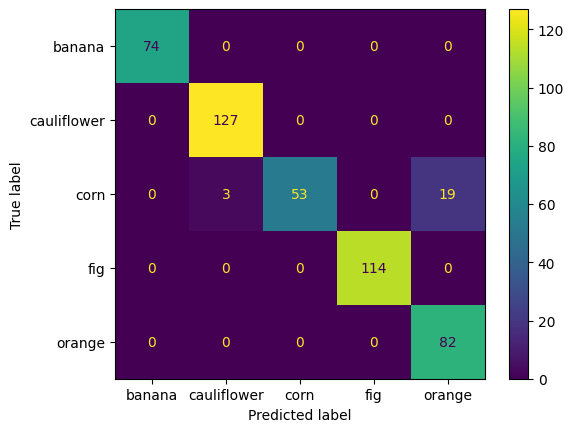

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(labels_total, prediction_total)
classes = ("banana", "cauliflower", "corn", "fig", "orange")
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()

#### Show some predictions

Labels:

fig,cauliflower,cauliflower,cauliflower,corn,cauliflower,corn,fig,orange,fig,banana,banana,corn,banana,orange,fig

Predictions:

fig,cauliflower,cauliflower,cauliflower,corn,cauliflower,orange,fig,orange,fig,banana,banana,orange,banana,orange,fig


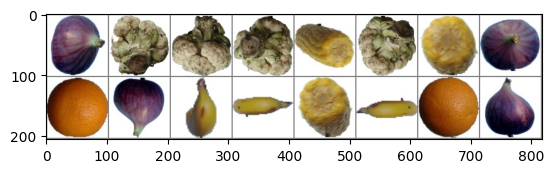

In [ ]:
# get some random training images
dataiter = iter(testloader)
images, labels =next(dataiter)    # or in previous version: dataiter.next()
outputs = mymodel(images.to(device))
_, predicted = torch.max(outputs.data, 1)

# print labels
print("Labels:\n")
print(','.join(dict2[int(labels[j])] for j in range(batch_size)))
print("\nPredictions:\n")
print(','.join(dict2[int(predicted[j])] for j in range(batch_size)))
# show images
imshow(torchvision.utils.make_grid(images))

#### Missed predictions

Labels:

corn

Predictions:

orange


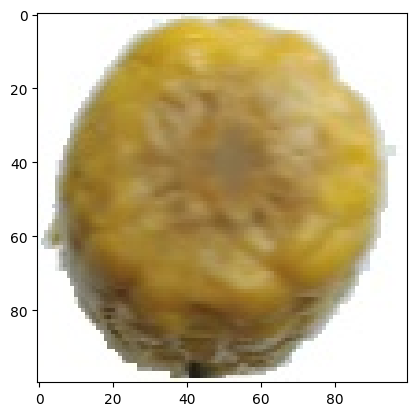

Labels:

corn

Predictions:

orange


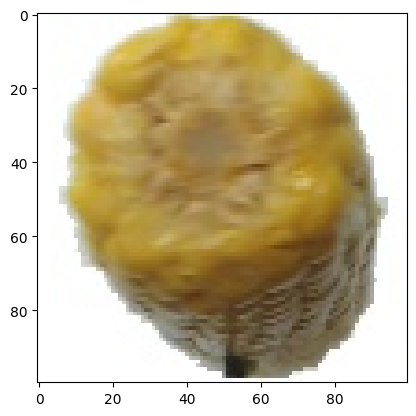

Labels:

corn

Predictions:

orange


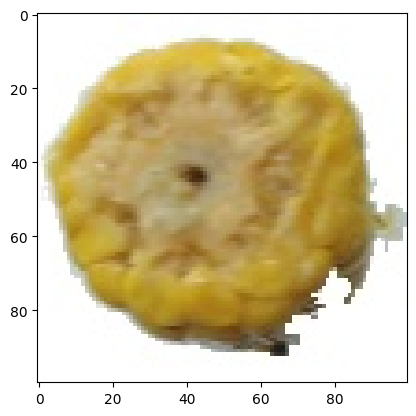

In [ ]:
batch_size=1
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)
dataiter = iter(testloader)

bad_predictions = 0
while bad_predictions < 3:
  images, labels =next(dataiter)    # or in previous version: dataiter.next()
  outputs = mymodel(images.to(device))
  _, predicted = torch.max(outputs.data, 1)

  if predicted.cpu() != labels:
    # print labels
    print("Labels:\n")
    print(','.join(dict2[int(labels[j])] for j in range(batch_size)))
    print("\nPredictions:\n")
    print(','.join(dict2[int(predicted[j])] for j in range(batch_size)))
    # show images
    imshow(torchvision.utils.make_grid(images))
    bad_predictions += 1

## 5. Some example questions that help you prepare for the defense

* Data
    - Describe your dataset.
    - List augmentation techniques.
    - Normalization standardization why do we use them?

* Model
    - Describe the model and its parameters (Convolutional Layer, Pooling
    - Layer, flatten, concatenation, activation, linear, argmax().
    - How can we change the output dimension? What happens if we change the head or the backbone? (filter number or replace them,...).

* optimizer
    - Describe the optimizer. What parameters does it have? (some connection to the date, model, and loss function)

* Loss function and regularisation
    - Describe the loss functions and some regularization methods.

* Results
    - Describe the results based on overfitting, underfitting, bias, and variance.
    - Does the trained model complete the given task? What is the baseline for classification?
    - Then the data balance, if it were unbalanced how would they deal with it?
    - What other aspects can cause biased output? What simple methods do we have to unbias the model?
    - Try to explain why it was difficult for the model to recognize the missed predictions.
    - How can we improve the model?

#### Answer the questions (optional, but recommended for the  preparation)

The modified version performed much better (95% accuracy on the test set) than AlexNet (35% accuracy), because it had an easier job, it had to distinguish only five classes, while AlexNet had to choose the corresct label from 1000 classes at each prediction.
And the five classes where quite different, while in the Imagenet dataset there are more similar classes.